# Hierarchical Clustering Validation Metrics Visualization

Plot validation metrics from hierarchical clustering analysis.

## 1. Import Required Libraries

In [55]:
import os 
import os.path as op
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, to_rgba
import matplotlib.image as mpimg
from matplotlib.lines import Line2D
from matplotlib import rcParams
from scipy.cluster.hierarchy import fcluster, dendrogram, linkage, set_link_color_palette
from scipy.spatial.distance import pdist
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 2. Directories and Load Metrics Data

In [56]:
data_dir = "./data"
figures_dir = "./figures/validation_metrics"
os.makedirs(figures_dir, exist_ok=True)
print(f"Figures will be saved to: {figures_dir}")

metrics_file = op.join(data_dir, "combined_validation_metrics.csv")
df = pd.read_csv(metrics_file)
print(f"Loaded metrics for k values: {df['k'].tolist()}")
print(f"\nAvailable metrics: {df.columns.tolist()}")
print(f"\nData preview:")
df.head(10)

Figures will be saved to: ./figures/validation_metrics
Loaded metrics for k values: [2, 3, 4, 5, 6, 7, 8, 9]

Available metrics: ['k', 'silhouette_score', 'gap_statistic', 'gap_std', 'vrc', 'wcss', 'bcss', 'total_ss', 'cluster_separation', 'hierarchy_index', 'cophenetic_correlation', 'group_sizes']

Data preview:


k  silhouette_score  gap_statistic   gap_std       vrc        wcss  \
0  2          0.007000       2.175489  0.000095  5.969058  698.605957   
1  3          0.005079       2.181402  0.000076  5.607236  693.460861   
2  4          0.004584       2.186725  0.000088  5.355063  688.754318   
3  5          0.002931       2.190896  0.000079  5.028212  684.860855   
4  6          0.002663       2.194295  0.000095  4.723339  681.512611   
5  7          0.001468       2.196852  0.000101  4.414490  678.780876   
6  8          0.001046       2.199292  0.000106  4.186927  676.108418   
7  9          0.001373       2.201426  0.000086  3.985582  673.676479   

        bcss    total_ss  cluster_separation  hierarchy_index  \
0   5.931749  704.537706            0.185290         0.931444   
1  11.078060  704.538921            0.220144         0.943879   
2  15.784549  704.538867            0.246170         0.932425   
3  19.677859  704.538714            0.282191         0.931151   
4  23.025861  704.538472            0.298260         0.925579   
5  25.757632  704.538508            0.312655         0.936161   
6  28.430006  704.538423            0.328761         0.938704   
7  30.861983  704.538462            0.332063         0.944186   

   cophenetic_correlation                             group_sizes  
0                     NaN                              [303, 402]  
1                     NaN                         [303, 205, 197]  
2                     NaN                    [155, 148, 205, 197]  
3                     NaN                [155, 148, 205, 65, 132]  
4                     NaN            [155, 148, 58, 147, 65, 132]  
5                     NaN         [155, 83, 65, 58, 147, 65, 132]  
6                     NaN      [155, 83, 65, 58, 147, 65, 39, 93]  
7                     NaN  [53, 102, 83, 65, 58, 147, 65, 39, 93]

## 3. Configure Plot Settings

In [57]:
sns.set_style("whitegrid") 
sns.set_context("paper", font_scale=1.5)

rcParams['text.usetex'] = False
rcParams['figure.dpi'] = 300
rcParams['savefig.dpi'] = 300
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = "Arial", "DejaVu Sans"
rcParams['font.size'] = 11
rcParams['axes.labelsize'] = 12
rcParams['axes.titlesize'] = 13
rcParams['xtick.labelsize'] = 11
rcParams['ytick.labelsize'] = 11
rcParams['legend.fontsize'] = 14
rcParams['figure.titlesize'] = 16

colors = {
    'cluster1': '#4168F6A0',
    'cluster2': '#1FDA4281',
    'cluster3': '#FE4AA4BE',
    'thresh_line': '#E10F0FFF',
    'silhouette': '#0C2AE8DB',
    'gap': '#F402A3DB',
    'vrc': '#0C9CAFE0',
    'separation': '#FF0B0BE6',
    'hierarchy': '#1CA514F8'}

cluster_palette = [
    colors['cluster1'],
    colors['cluster2'],
    colors['cluster3'],
]
 

## 4. Plot Dendrogram Color Assignment (k=3)

Cluster 1: blue, Cluster 2: green, and Cluster 3: pink

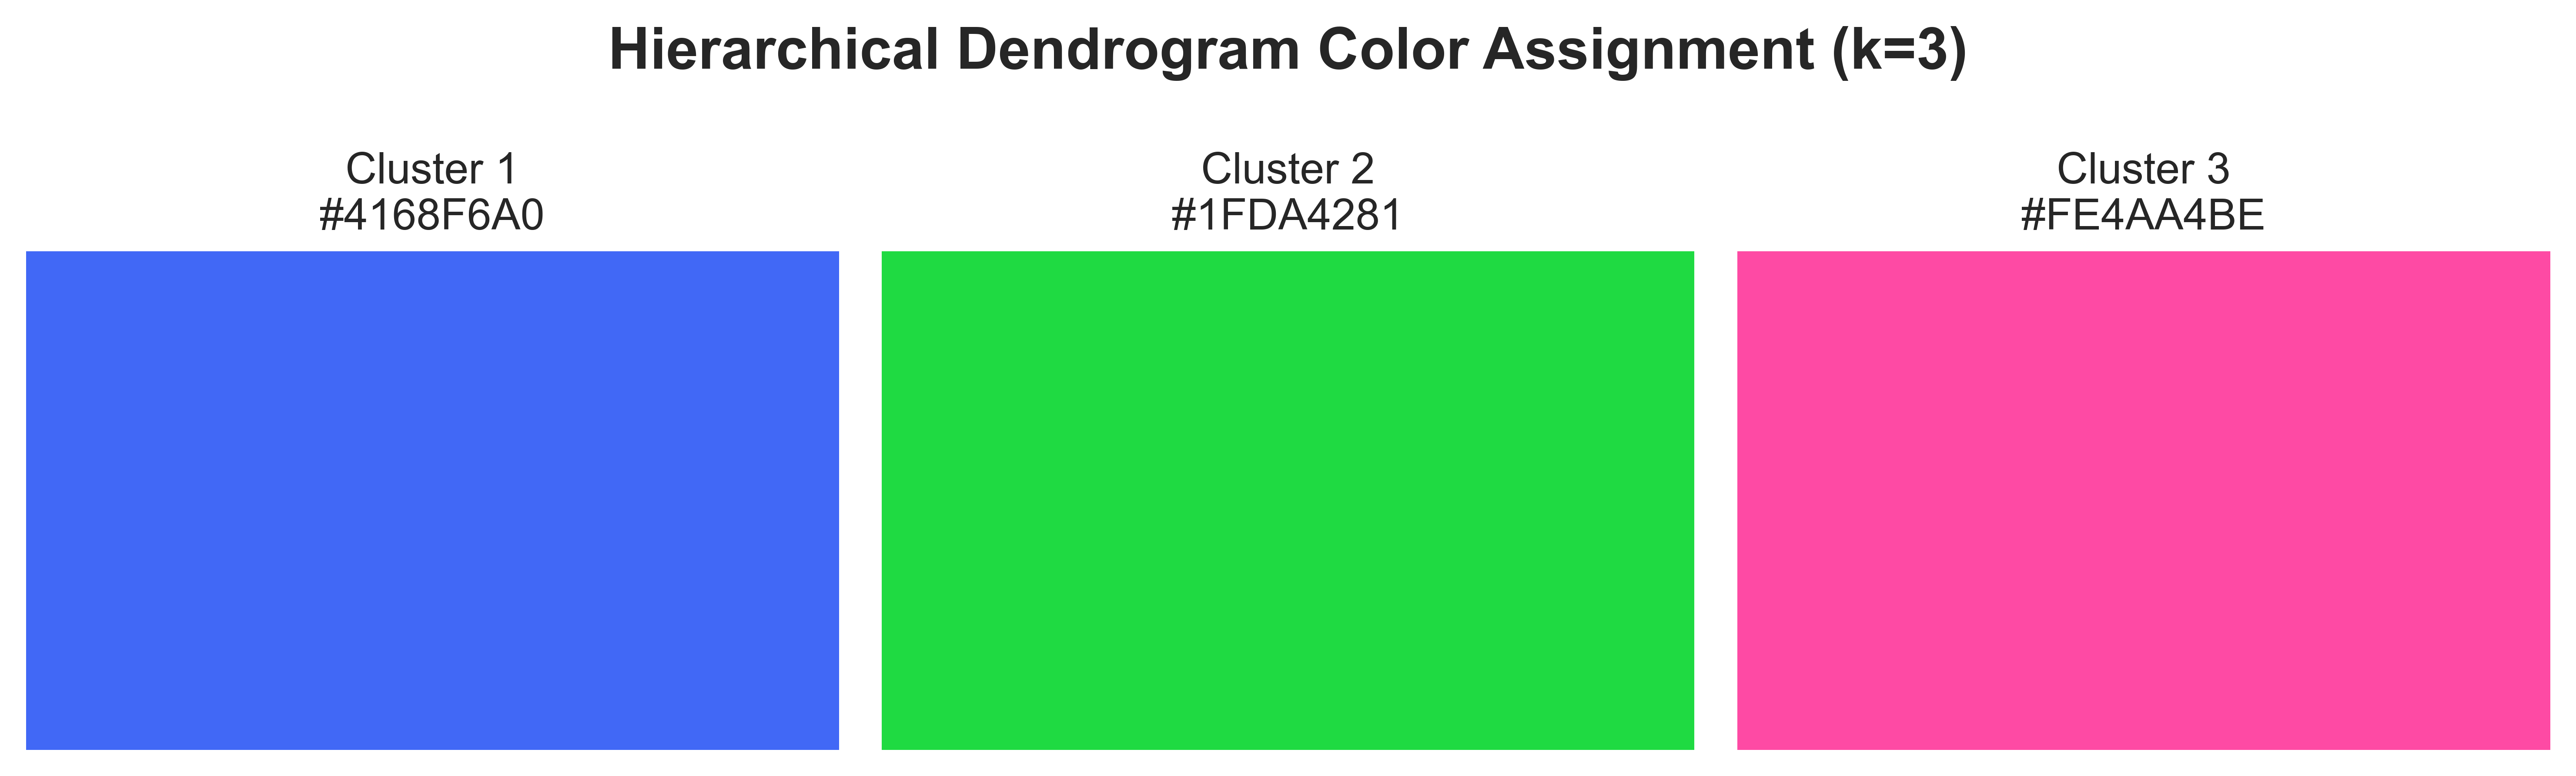

In [59]:
def cluster_palette_to_cmap(hex_color, name):
    rgba = to_rgba(hex_color)
    return ListedColormap([rgba], name=name)
cmaps = {
    i: cluster_palette_to_cmap(cluster_palette[i], name=f"f_cluster_{i}")
    for i in range(len(cluster_palette))
}
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
fig.suptitle("Hierarchical Dendrogram Color Assignment (k=3)", fontsize=16, fontweight='bold')

for i, color in enumerate(cluster_palette):
    ax = axes[i]
    gradient = np.ones((10, 100, 3))
    rgb = tuple(int(color.lstrip('#')[j:j+2], 16)/255. for j in (0, 2, 4))
    gradient[:] = rgb
    ax.imshow(gradient, aspect='auto')
    ax.set_title(f"Cluster {i+1}\n{color}", fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 5. Create Individual Metric Plots

### 5.1.1 Compute Hierarchical Clustering

In [ ]:
data_path = "./data/clustering_data_matrix.npy"
data_matrix = np.load(data_path)

Xc = data_matrix - data_matrix.mean(axis=1, keepdims=True)
n = np.linalg.norm(Xc, axis=1, keepdims=True)
n = np.where(n == 0, 1.0, n)
Xcorr = Xc / n
metric = "euclidean"
method = "ward"
condensed = pdist(Xcorr, metric=metric)
linkage_matrix = linkage(condensed, method=method)
distances = linkage_matrix[:, 2]
n = linkage_matrix.shape[0] + 1  

def threshold_for_k(Z, k):
    n = Z.shape[0] + 1
    lo_idx = n - k - 1
    hi_idx = n - k
    lo = Z[lo_idx, 2] if lo_idx >= 0 else 0.0
    hi = Z[hi_idx, 2]
    t = (lo + hi) / 2.0 if hi != lo else hi * 0.9999
    return t
threshold = {k: float(threshold_for_k(linkage_matrix, k)) for k in range(2, 10)}
merge_ld = {
    k: float(linkage_matrix[linkage_matrix.shape[0] - k, 2])
    for k in range (2, 10)
}
jump_ld = {
    k: float(merge_ld[k] - merge_ld[k+1])
    for k in range (2, 10)
}
delta = '\u0394'
best_k = max(jump_ld, key=jump_ld.get)
print(f"Threshold (midpoint): {threshold}")
print(f"Merge Linkage Distance: {merge_ld}")
print(f"{delta} Linkage Distance: {jump_ld}")
print(f"Best k: {best_k}")

Threshold (midpoint): {2: 3.326277271865286, 3: 3.1381346910909658, 4: 2.9292545830305694, 5: 2.6890576241159376, 6: 2.4625428495932375, 7: 2.324646543068556, 8: 2.258654332603185, 9: 2.1862043348692586}
Merge Linkage Distance: {2: 3.20821167922785, 3: 3.0680577029540816, 4: 2.790451463107057, 5: 2.5876637851248185, 6: 2.337421914061656, 7: 2.311871172075456, 8: 2.2054374931309133, 9: 2.1669711766076034}
Δ Linkage Distance: {2: 0.14015397627376824, 3: 0.2776062398470245, 4: 0.20278767798223862, 5: 0.2502418710631624, 6: 0.0255507419862, 7: 0.10643367894454281, 8: 0.038466316523309896}
Best k: 3


### 5.1.2 Plot Hierarchical Dendrogram

Saved: ./figures/validation_metrics/hierarchical_dendrogram.png


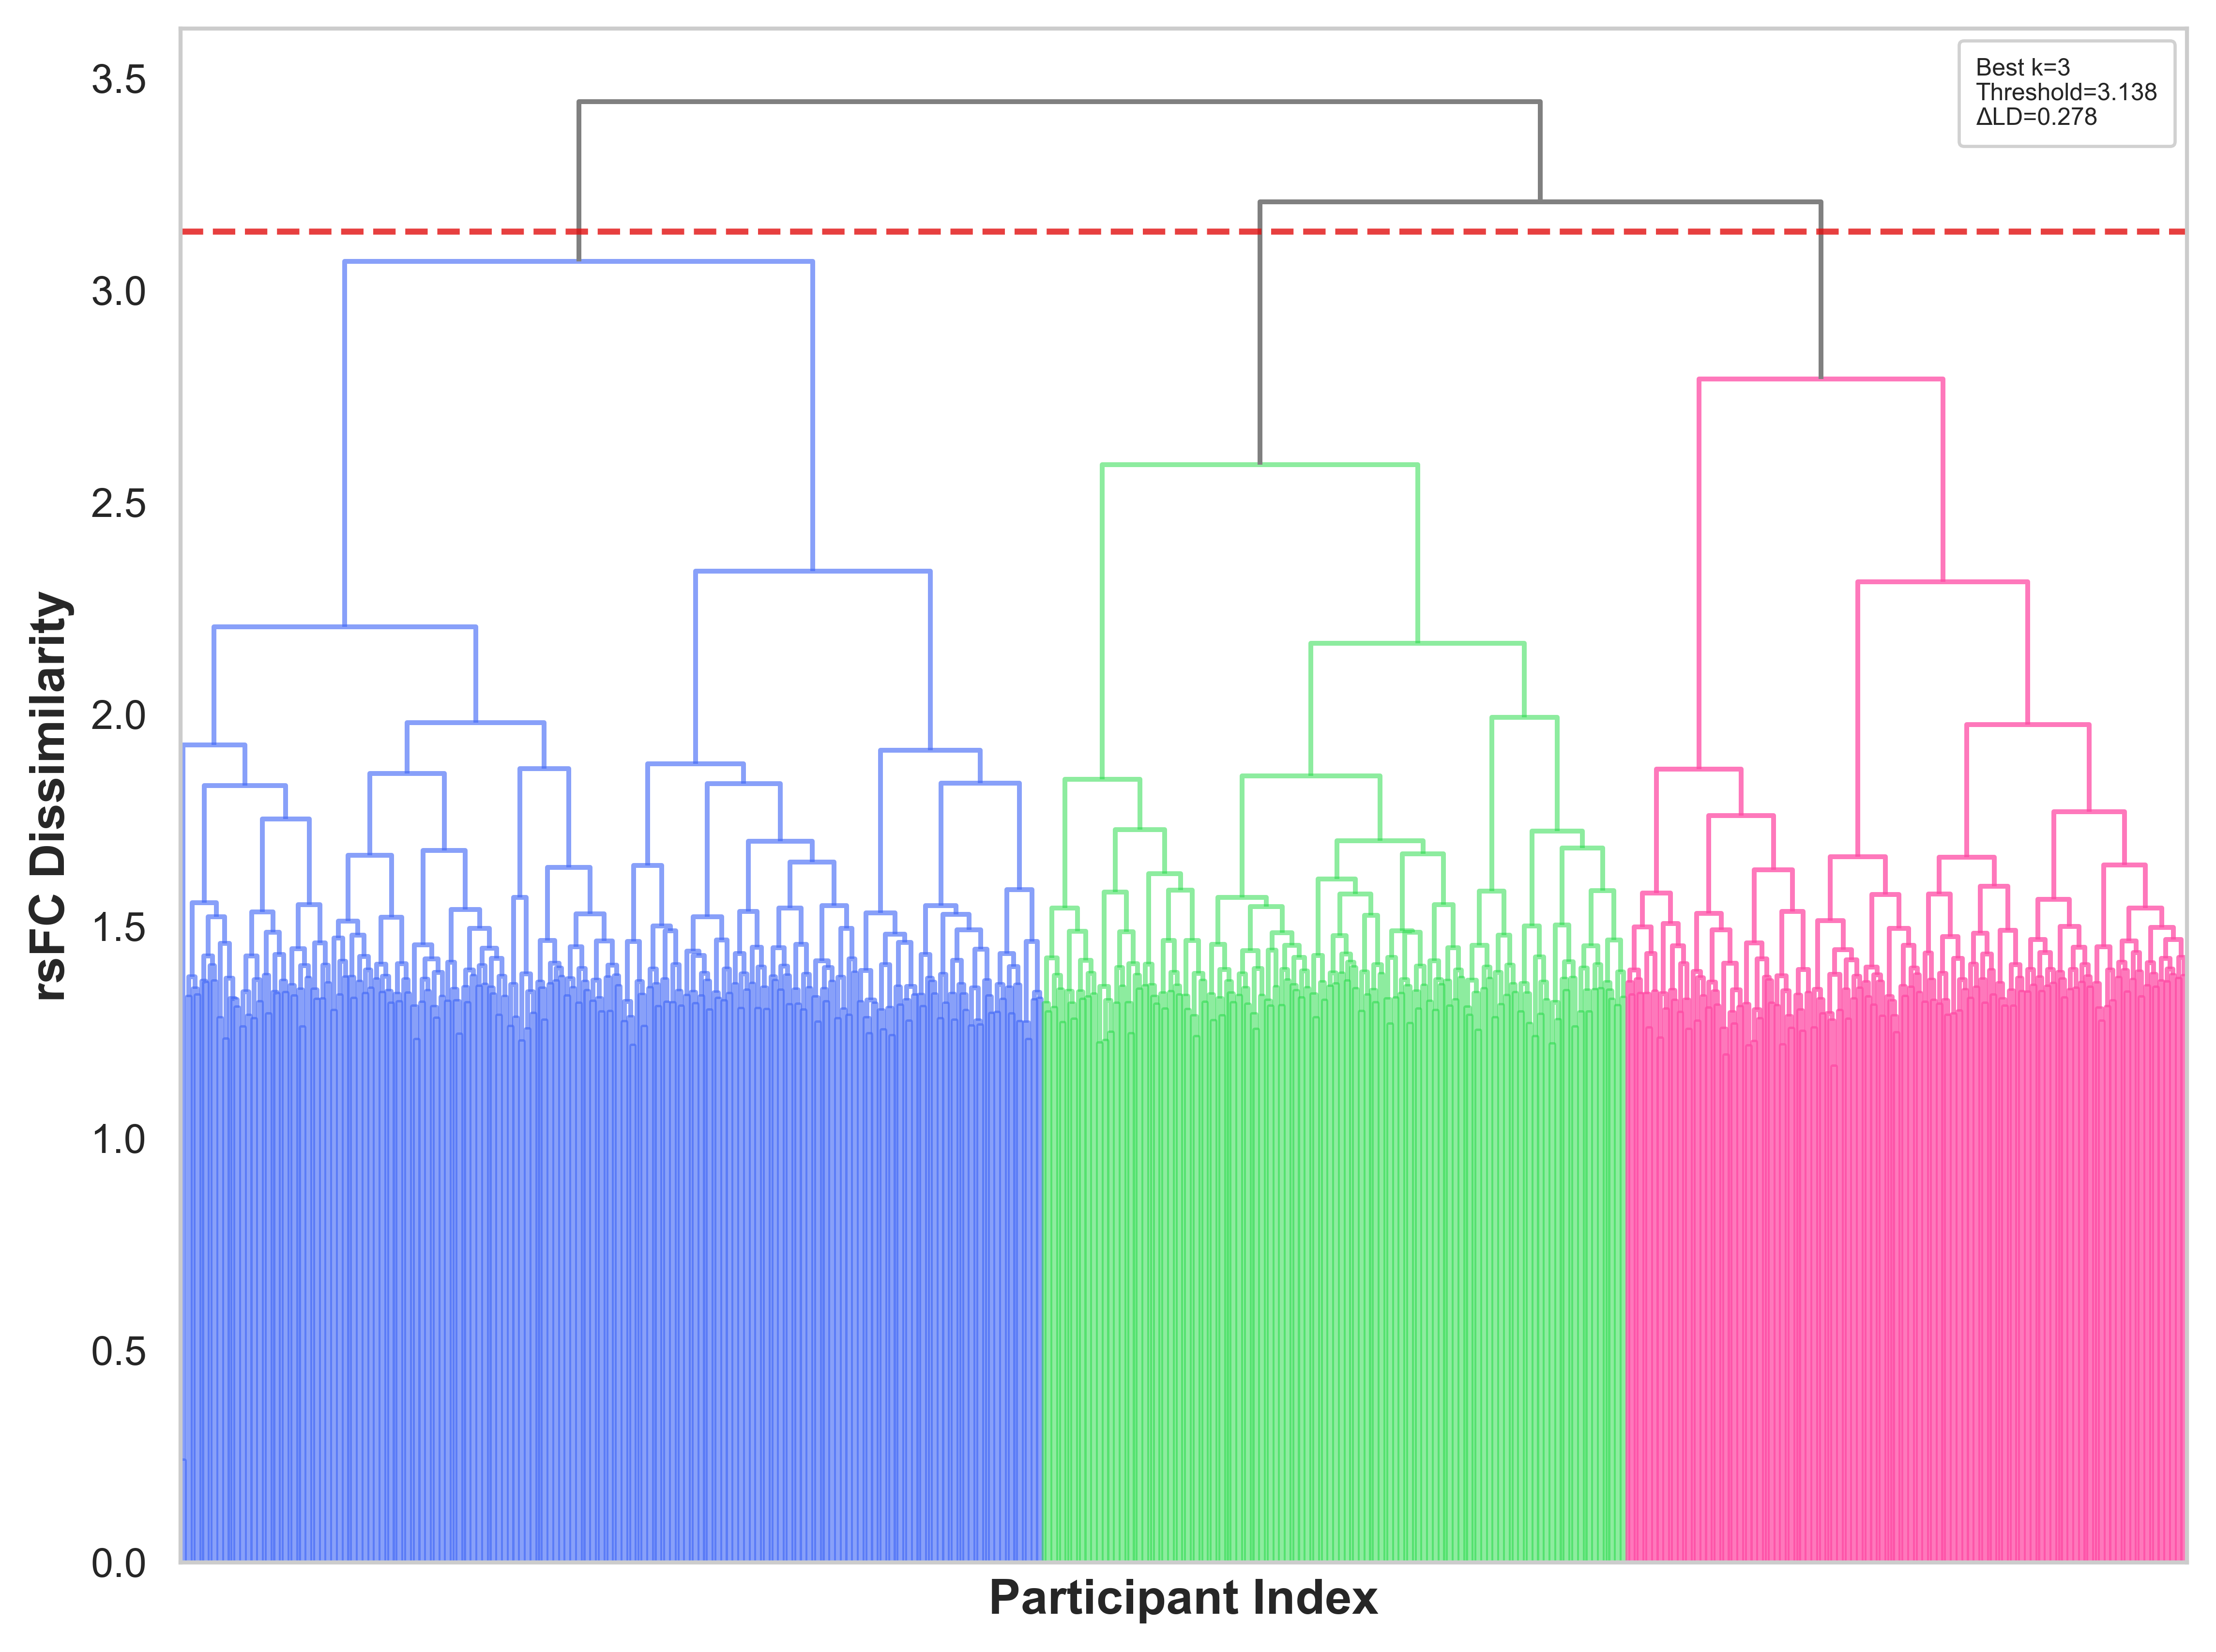

In [63]:
fig, ax = plt.subplots(figsize=(8, 6))
set_link_color_palette(cluster_palette)
cluster_labels = fcluster(linkage_matrix, t=best_k, criterion="maxclust")
cluster_colors = [cluster_palette[label-1] for label in cluster_labels]

def link_color_func(link):
    if link < len(cluster_labels):
        return cluster_colors[link]
    else:
        left = int(linkage_matrix[link - len(cluster_labels), 0])
        right = int(linkage_matrix[link - len(cluster_labels), 1])
        left_color = link_color_func(left)
        right_color = link_color_func(right)
        return left_color if left_color == right_color else "gray"
dendrogram(
    linkage_matrix,
    ax=ax,
    color_threshold=np.inf,
    link_color_func=link_color_func,
    above_threshold_color="gray",
    no_labels=True,
    leaf_font_size=10,
)
ax.axhline(y=threshold[best_k], color=colors['thresh_line'], linestyle='--', linewidth=1.5, alpha=0.8)
for label in ax.get_yticklabels():
    label.set_fontsize(10)

delta = "\u0394"
legend = [
    f"Best k={best_k}",
    f"Threshold={threshold[best_k]:.3f}",
    f"{delta}LD={jump_ld[best_k]:.3f}"]
empty_handles = [Line2D([0], [0], color='none') for _ in legend]
ax.legend(handles=empty_handles, labels=legend, loc='upper right', frameon=True, framealpha=0.9, handlelength=0, 
    handletextpad=0, borderaxespad=0.5, borderpad=0.7, labelspacing=0.1, fontsize=6)
ax.set_xlabel("Participant Index", fontweight='bold')
ax.set_ylabel("rsFC Dissimilarity", fontweight='bold') 
ax.yaxis.grid(False)
plt.tight_layout(rect=[0, 0, 0.97, 0.97])
plt.subplots_adjust(wspace=0.2)

filepath = op.join(figures_dir, 'hierarchical_dendrogram.png')
plt.savefig(filepath, dpi=300, bbox_inches='tight')
print(f"Saved: {filepath}")
plt.show()

### 5.2 Silhouette Score

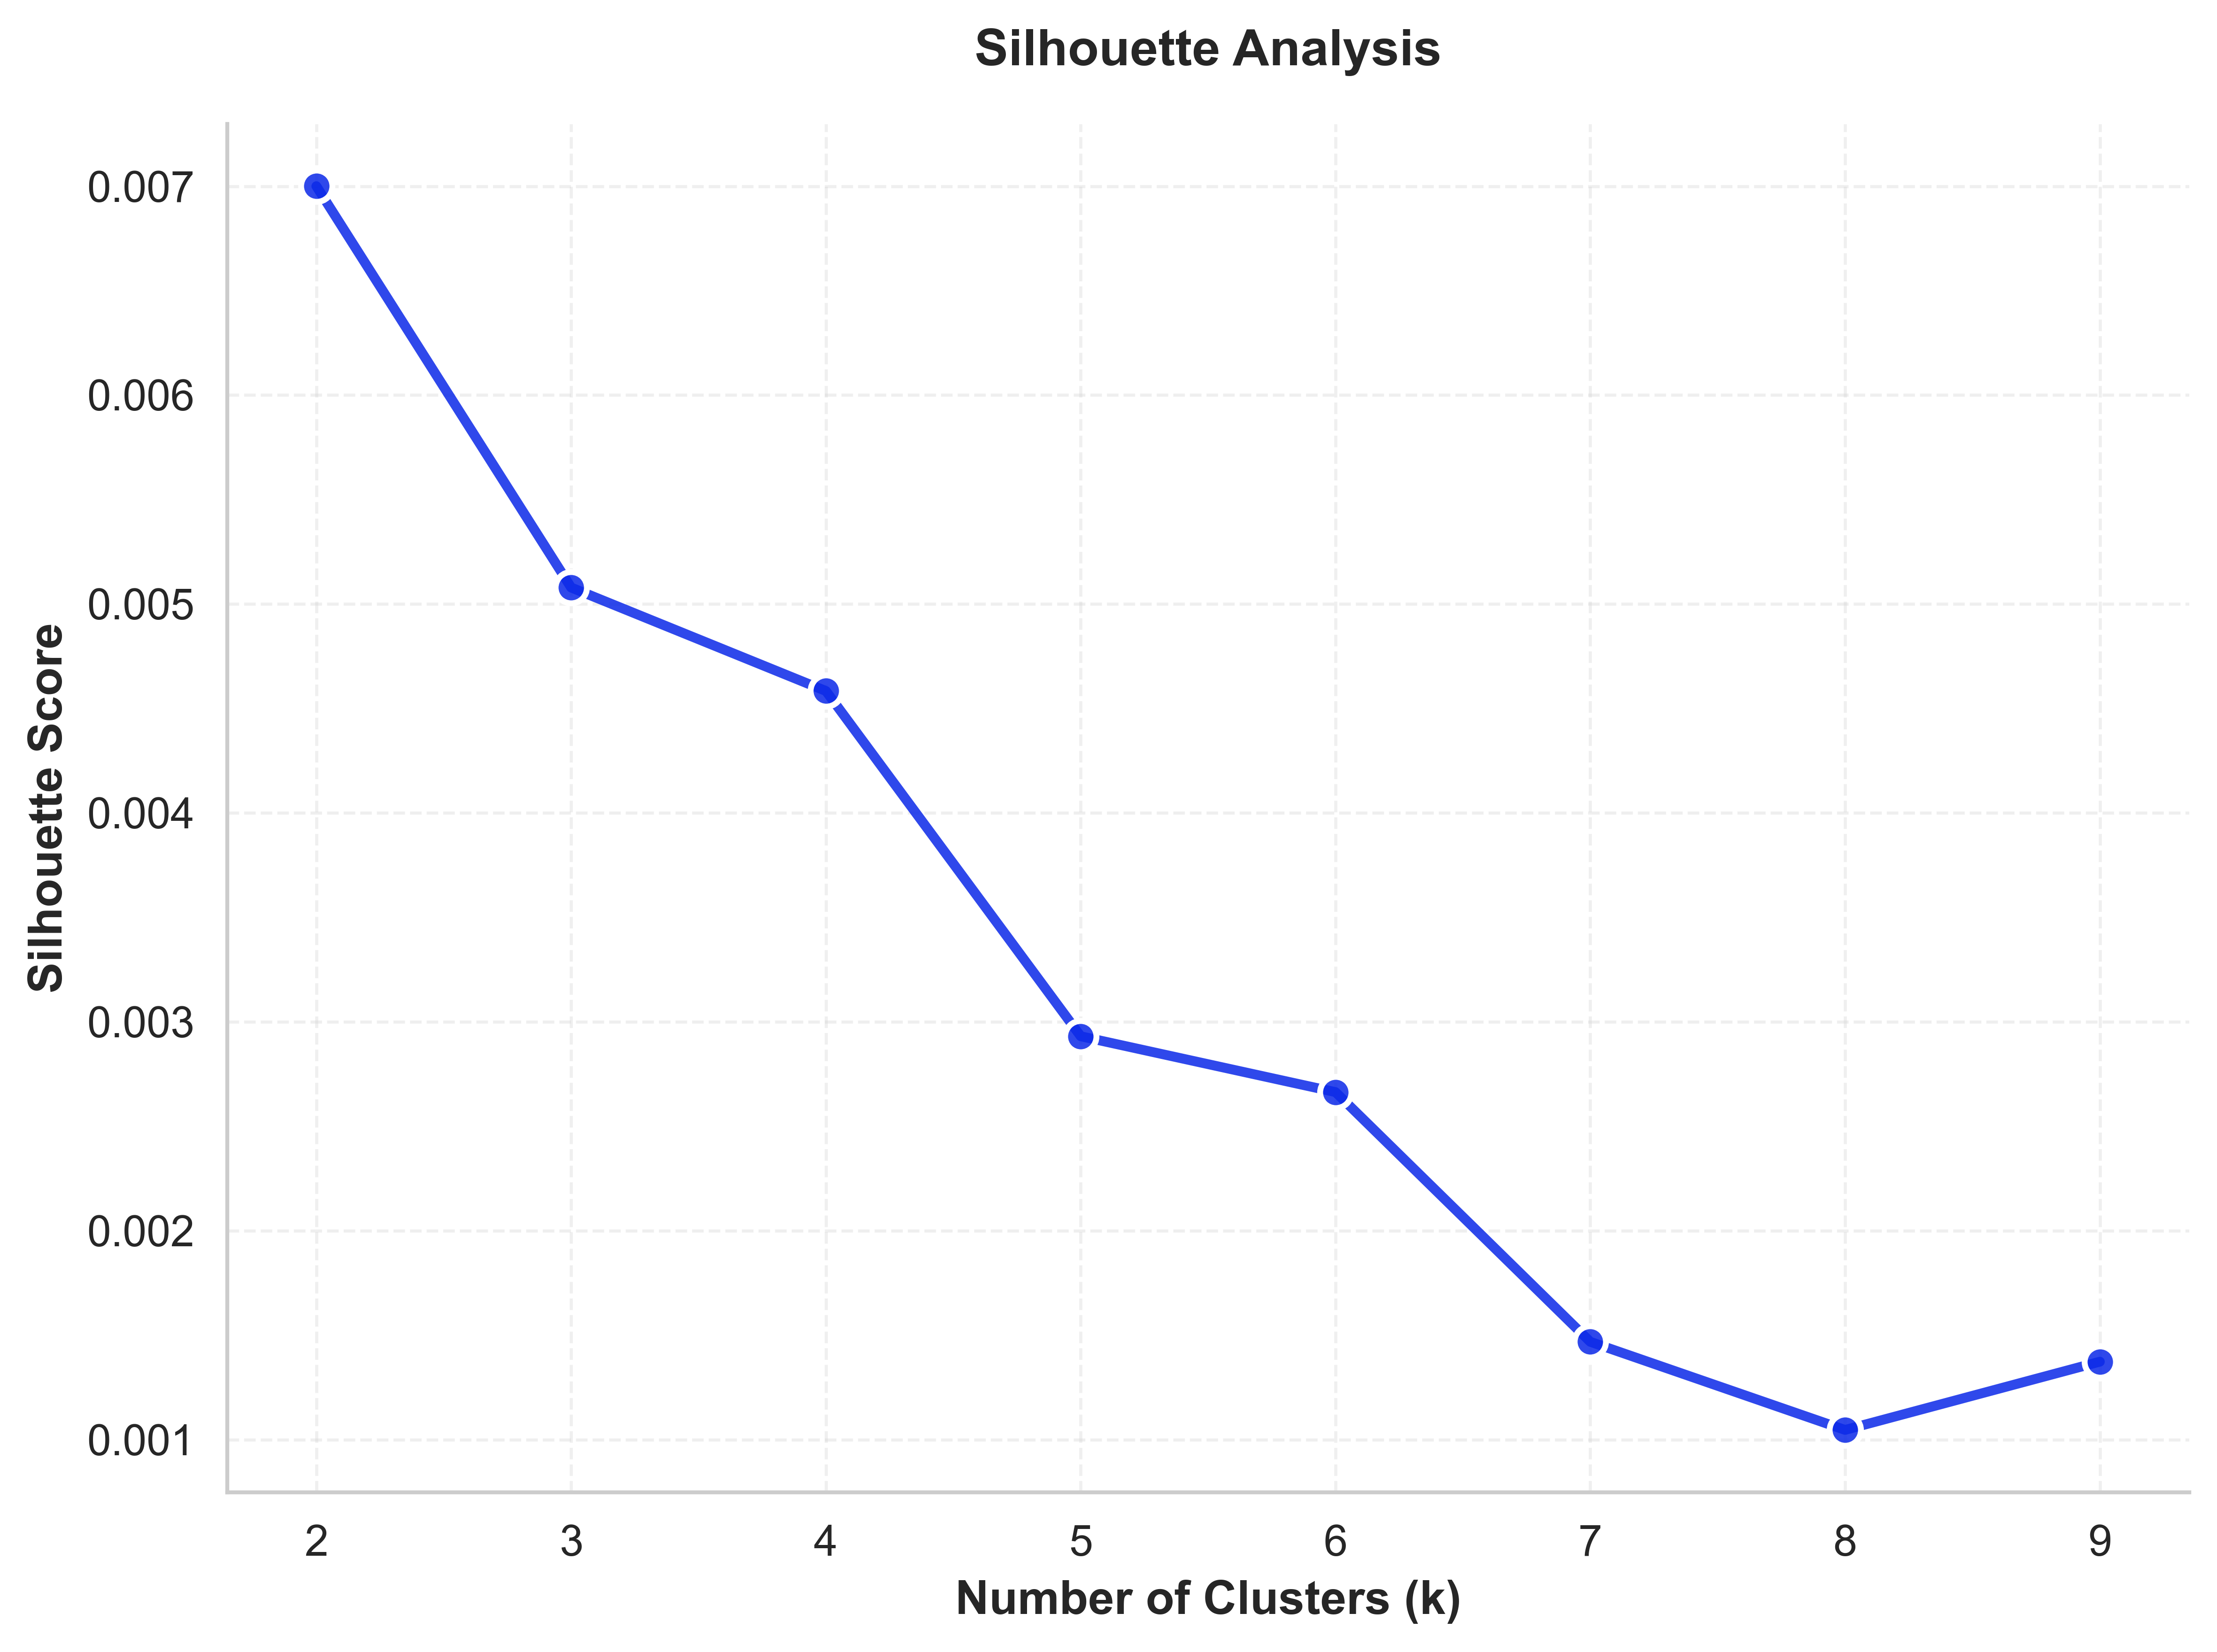

In [64]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(df['k'], df['silhouette_score'], 'o-', 
        linewidth=2.5, markersize=8, color=colors['silhouette'],
        markeredgecolor='white', markeredgewidth=1.5)

ax.set_xlabel('Number of Clusters (k)', fontweight='bold')
ax.set_ylabel('Silhouette Score', fontweight='bold')
ax.set_title('Silhouette Analysis', fontweight='bold', pad=15)
ax.set_xticks(df['k'])
ax.grid(True, alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### 5.3 Gap Statistic

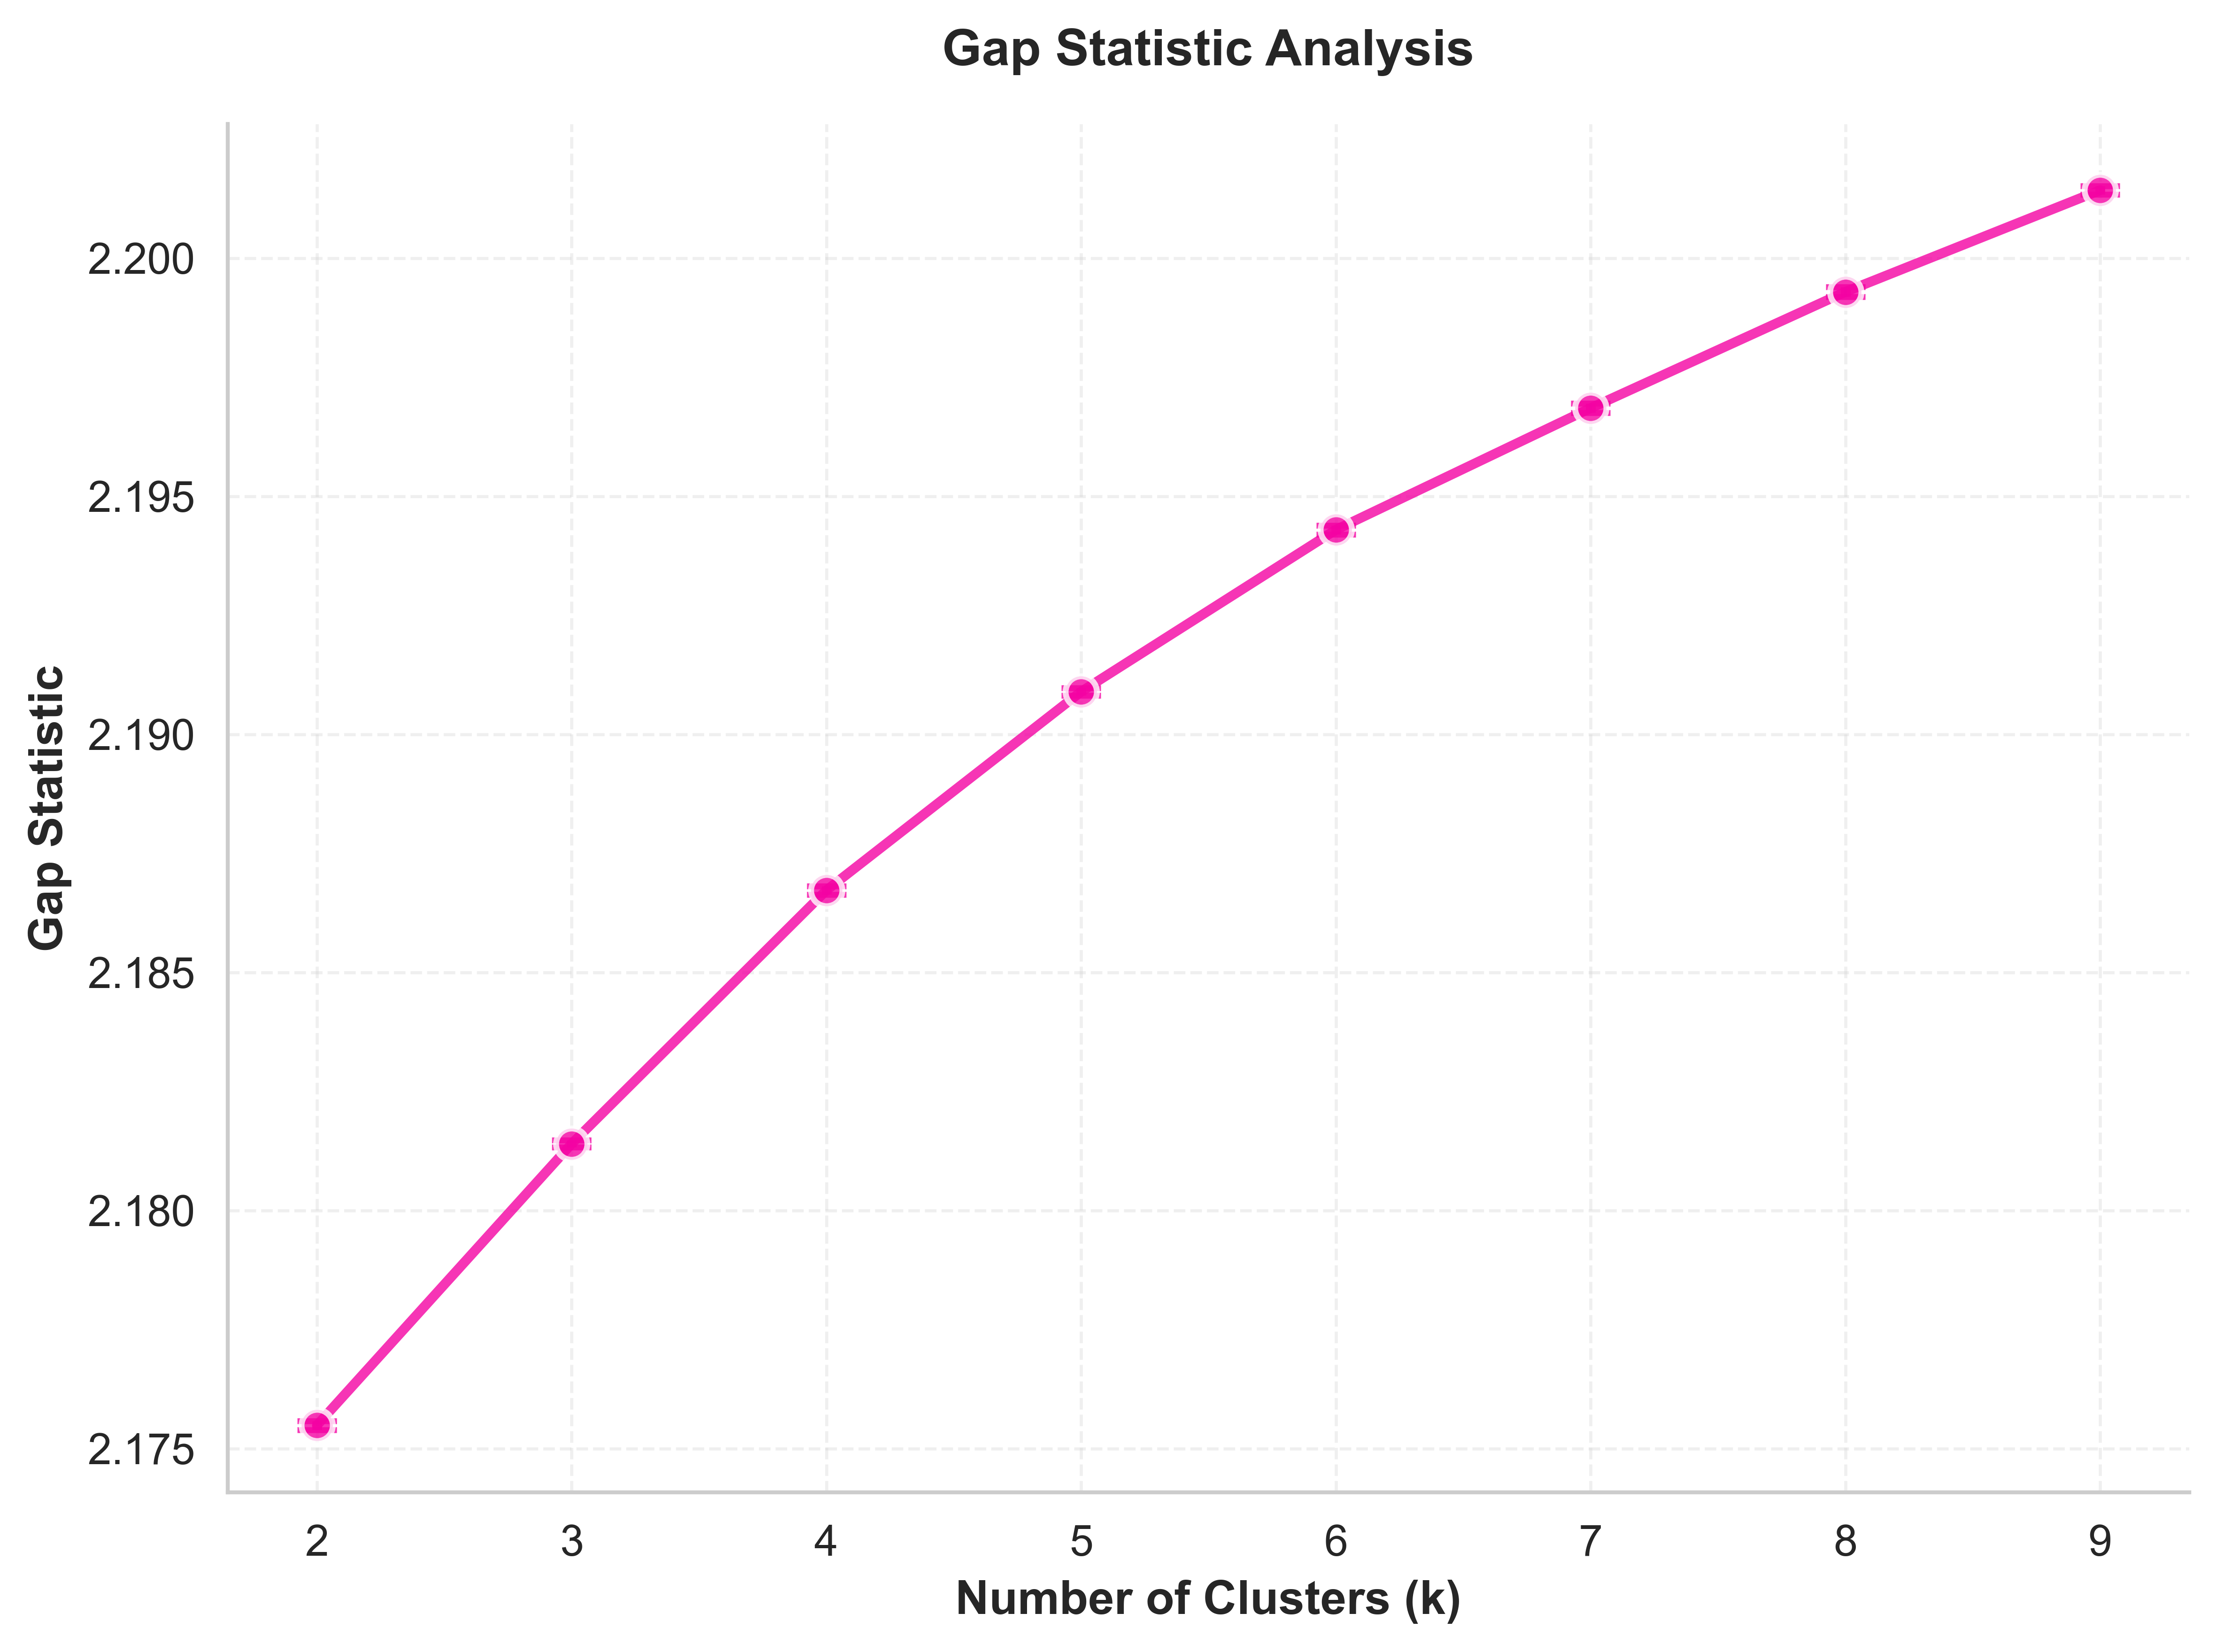

In [65]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.errorbar(df['k'], df['gap_statistic'], yerr=df['gap_std'],
            fmt='o-', linewidth=2.5, markersize=8, 
            color=colors['gap'], capsize=5, capthick=2,
            markeredgecolor='white', markeredgewidth=1.5,
            ecolor=colors['gap'], alpha=0.8)

ax.set_xlabel('Number of Clusters (k)', fontweight='bold')
ax.set_ylabel('Gap Statistic', fontweight='bold')
ax.set_title('Gap Statistic Analysis', fontweight='bold', pad=15)
ax.set_xticks(df['k'])
ax.grid(True, alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### 5.4 Caliński-Harabasz Index (VRC)

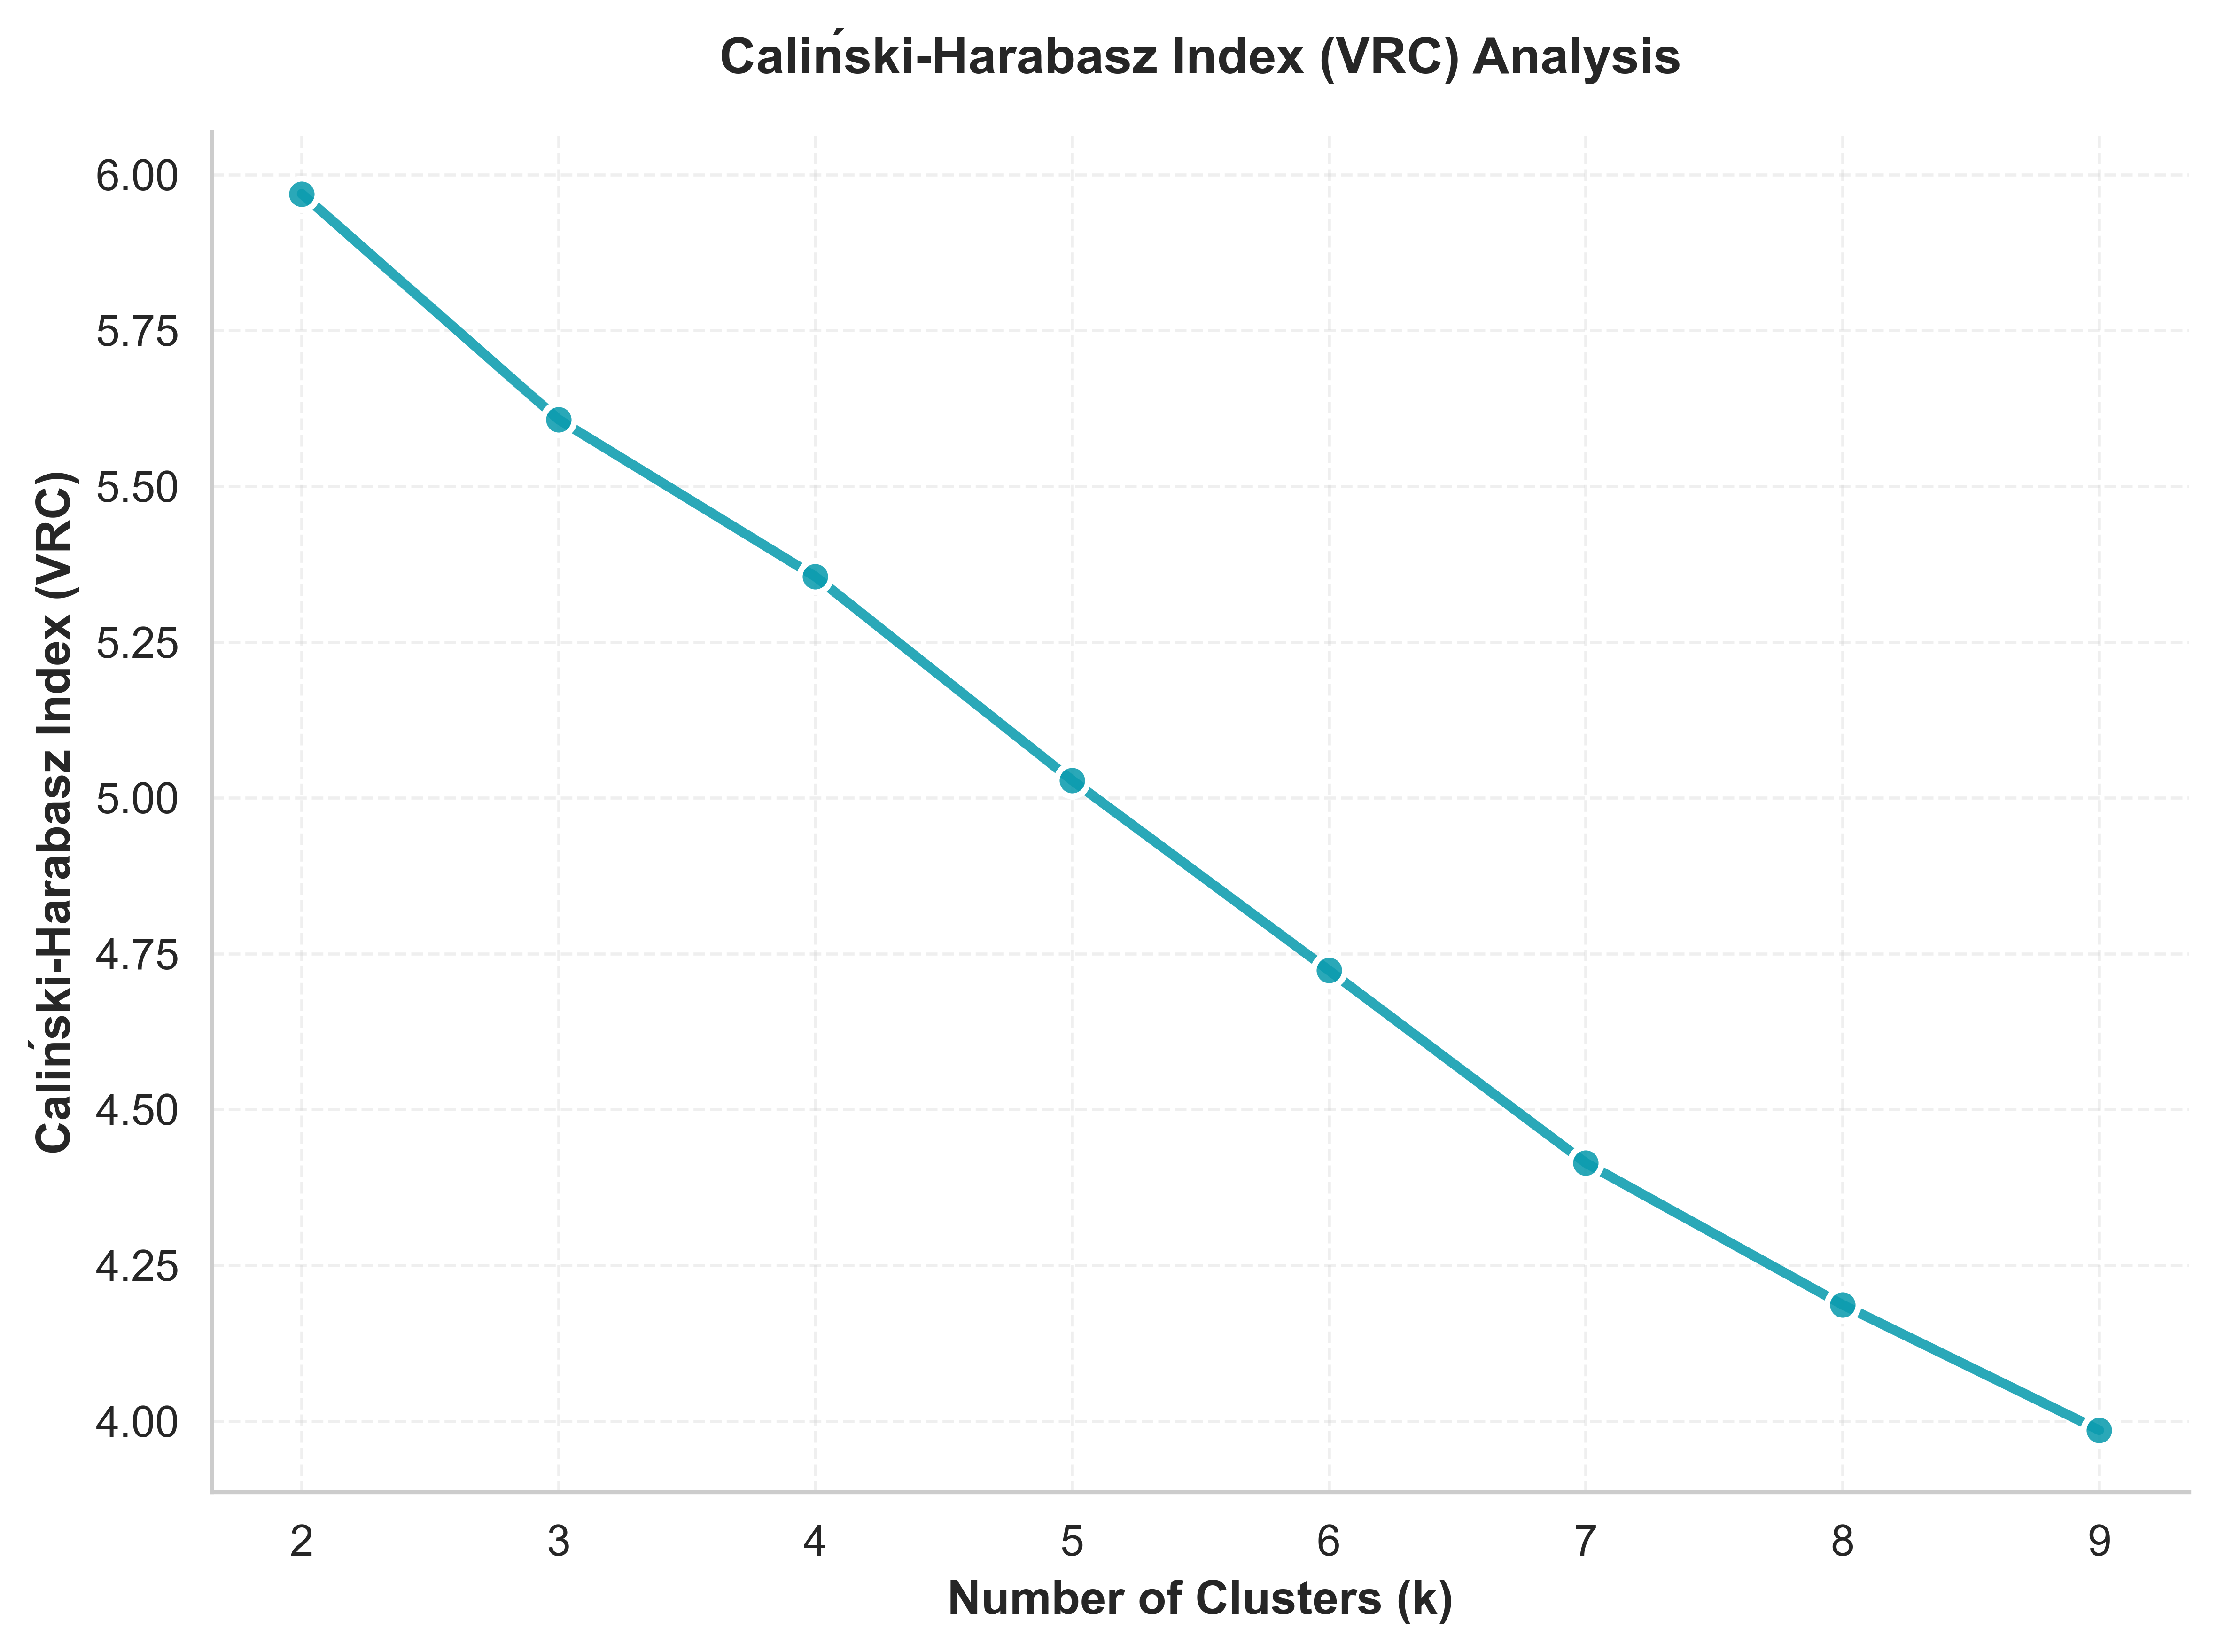

In [66]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(df['k'], df['vrc'], 'o-', 
        linewidth=2.5, markersize=8, color=colors['vrc'],
        markeredgecolor='white', markeredgewidth=1.5)

ax.set_xlabel('Number of Clusters (k)', fontweight='bold')
ax.set_ylabel('Caliński-Harabasz Index (VRC)', fontweight='bold')
ax.set_title('Caliński-Harabasz Index (VRC) Analysis', fontweight='bold', pad=15)
ax.set_xticks(df['k'])
ax.grid(True, alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### 5.5 Cluster Separation

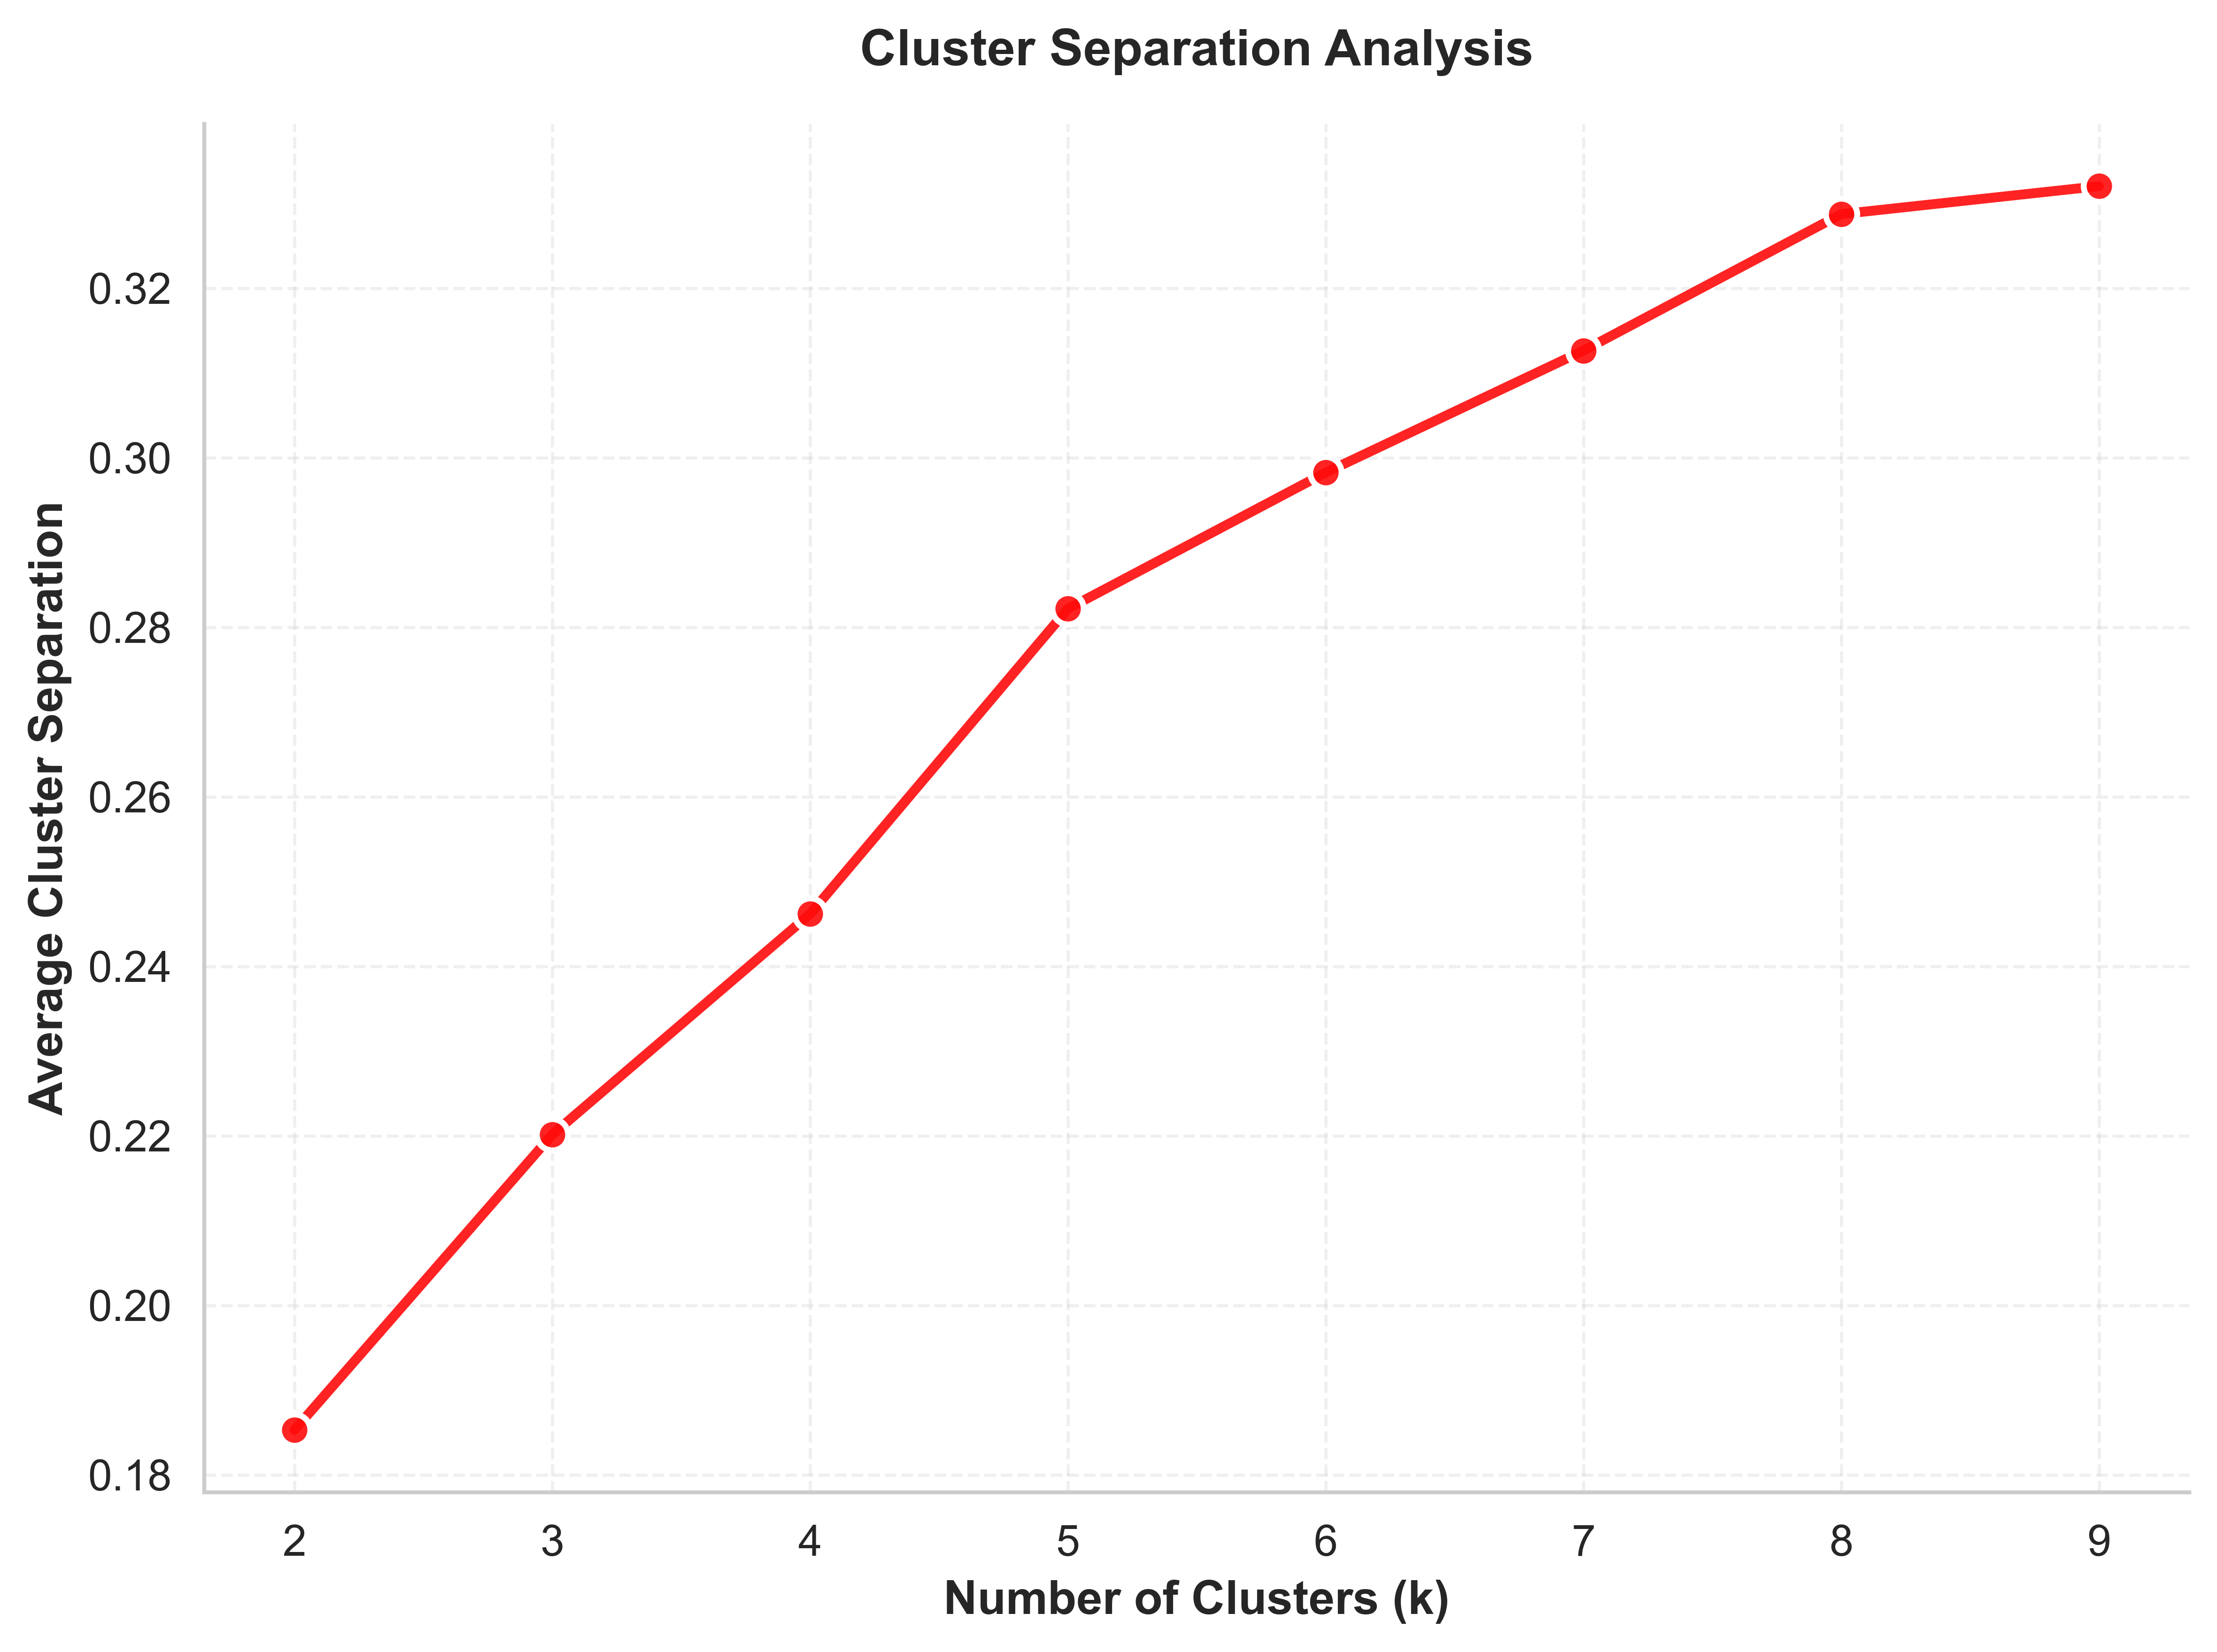

In [67]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(df['k'], df['cluster_separation'], 'o-', 
        linewidth=2.5, markersize=8, color=colors['separation'],
        markeredgecolor='white', markeredgewidth=1.5)

ax = plt.gca()
ax.set_xlabel('Number of Clusters (k)', fontweight='bold')
ax.set_ylabel('Average Cluster Separation', fontweight='bold')
ax.set_title('Cluster Separation Analysis', fontweight='bold', pad=15)
ax.set_xticks(df['k'])
ax.grid(True, alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### 5.6 Hierarchy Index

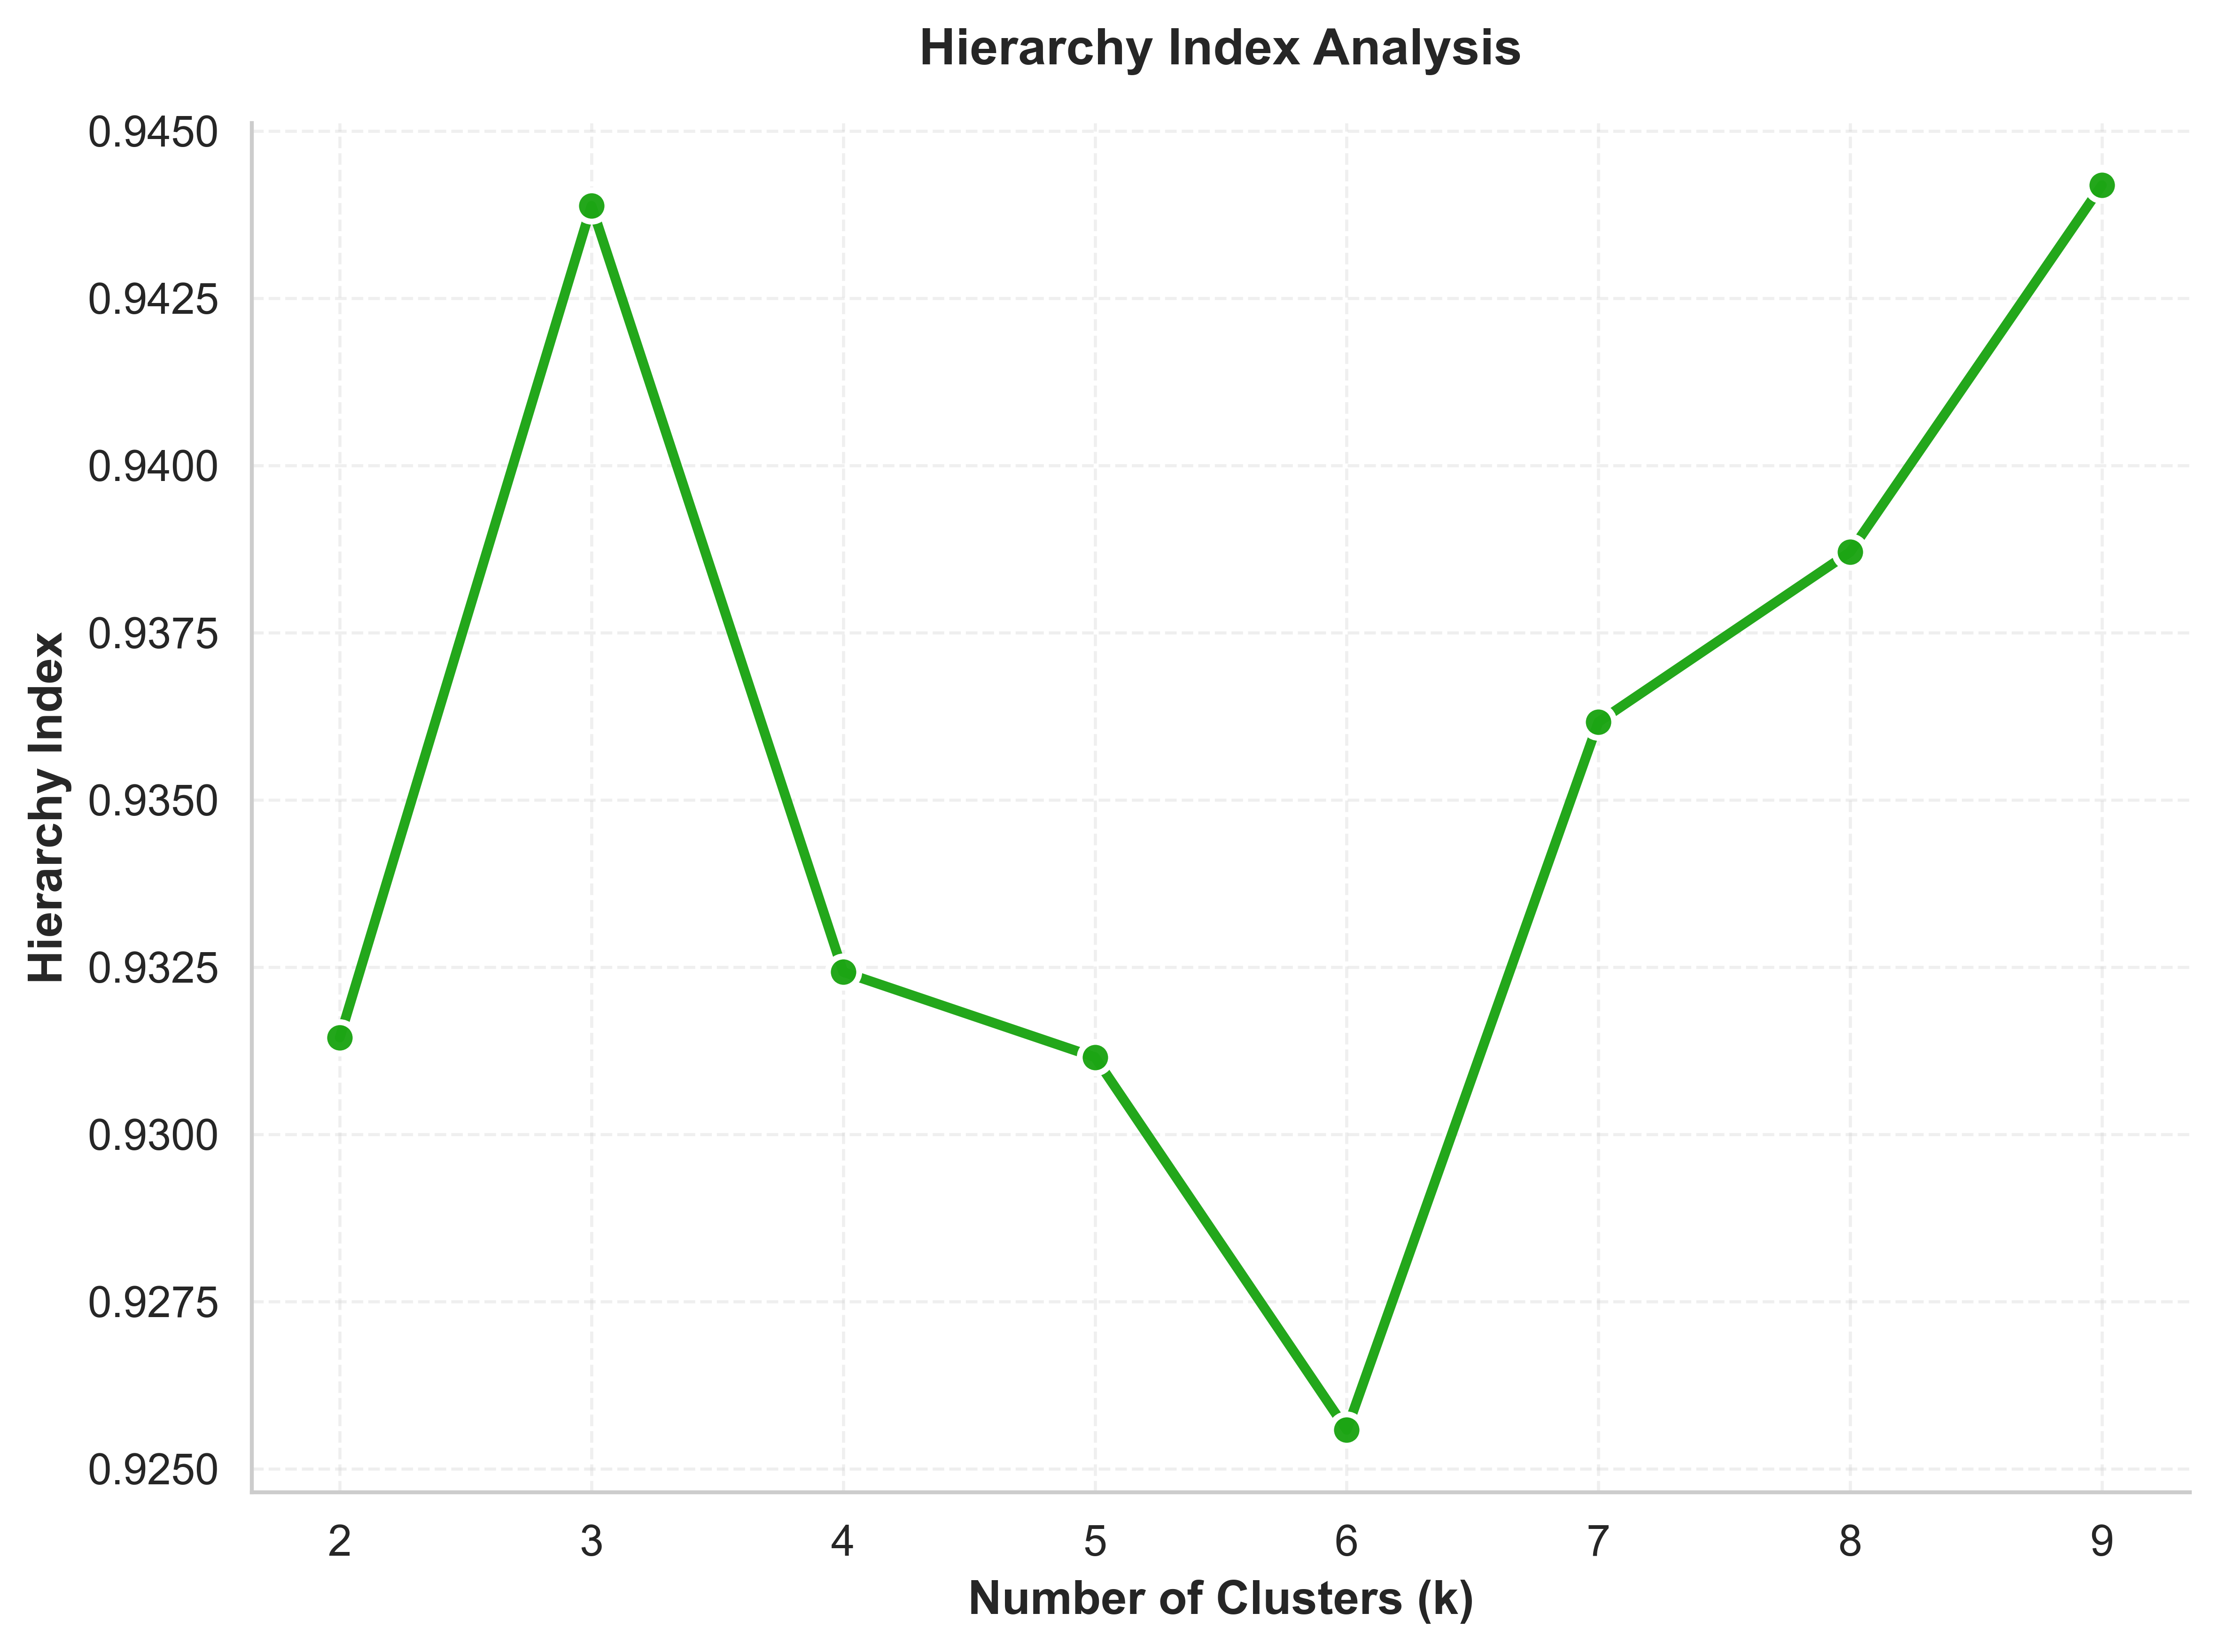

In [68]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(df['k'], df['hierarchy_index'], 'o-', 
        linewidth=2.5, markersize=8, color=colors['hierarchy'],
        markeredgecolor='white', markeredgewidth=1.5)

ax.set_xlabel('Number of Clusters (k)', fontweight='bold')
ax.set_ylabel('Hierarchy Index', fontweight='bold')
ax.set_title('Hierarchy Index Analysis', fontweight='bold', pad=15)
ax.set_xticks(df['k'])
ax.grid(True, alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

## 6. Combined Multi-Panel Figure

In [69]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18,10), constrained_layout=True)
gs = plt.GridSpec(2, 3, figure=fig, hspace=0.06)

# 1. Silhouette Score
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(df['k'], df['silhouette_score'], 'o-', 
        linewidth=2, markersize=7, color=colors['silhouette'])
ax1.set_xlabel('Number of Clusters (k)', fontweight='bold')
ax1.set_ylabel('Silhouette Score', fontweight='bold')
ax1.set_title('i)', fontsize=16, fontweight='bold', loc='left')
ax1.set_xticks(df['k'])
ax1.grid(True, alpha=0.3)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# 2. Gap Statistic
ax2 = fig.add_subplot(gs[0, 1])
ax2.errorbar(df['k'], df['gap_statistic'], yerr=df['gap_std'], fmt='o-', linewidth=2, markersize=7,
            color=colors['gap'], capsize=4)
ax2.set_xlabel('Number of Clusters (k)', fontweight='bold')
ax2.set_ylabel('Gap Statistic', fontweight='bold')
ax2.set_title('ii)', fontsize=16, fontweight='bold', loc='left')
ax2.set_xticks(df['k'])
ax2.grid(True, alpha=0.3)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# 3. VRC
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(df['k'], df['vrc'], 'o-', linewidth=2, markersize=7, color=colors['vrc'])
ax3.set_xlabel('Number of Clusters (k)', fontweight='bold')
ax3.set_ylabel('VRC', fontweight='bold')
ax3.set_title('iii)', fontsize=16, fontweight='bold', loc='left')
ax3.set_xticks(df['k'])
ax3.grid(True, alpha=0.3)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# 4. Cluster Separation
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(df['k'], df['cluster_separation'], 'o-', linewidth=2, markersize=7, color=colors['separation'])
ax4.set_xlabel('Number of Clusters (k)', fontweight='bold')
ax4.set_ylabel('Cluster Separation', fontweight='bold')
ax4.set_title('iv)', fontsize=16, fontweight='bold', loc='left')
ax4.set_xticks(df['k'])
ax4.grid(True, alpha=0.3)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

# 5. Hierarchy Index
ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(df['k'], df['hierarchy_index'], 'o-', linewidth=2, markersize=7, color=colors['hierarchy'])
ax5.set_xlabel('Number of Clusters (k)', fontweight='bold')
ax5.set_ylabel('Hierarchy Index', fontweight='bold')
ax5.set_title('v)', fontsize=16, fontweight='bold', loc='left')
ax5.set_xticks(df['k'])
ax5.grid(True, alpha=0.3)
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)

# 6. Hierarchical Dendrogram 
ax6 = fig.add_subplot(gs[1, 2])
dendrogram(
    linkage_matrix,
    ax=ax6,
    color_threshold=np.inf,
    link_color_func=link_color_func,
    above_threshold_color="gray",
    no_labels=True,
    leaf_font_size=10
)
ax6.axhline(y=threshold[best_k], color=colors['thresh_line'], linestyle='--', linewidth=1.5, alpha=0.8)
for label in ax6.get_yticklabels():
    label.set_fontsize(11)
delta = "\u0394"
legend = [
    f"k={best_k}, {delta}LD={jump_ld[best_k]:.3f}"]
empty_handles = [Line2D([0], [0], color='none') for _ in legend]
ax6.legend(handles=empty_handles, labels=legend, loc='upper right', frameon=True, framealpha=0.9, handlelength=0, 
    handletextpad=0, borderaxespad=0.4, borderpad=0.4, labelspacing=0.15, fontsize=9)
ax6.set_xlabel("Participant Index", fontweight='bold')
ax6.set_ylabel("rsFC Dissimilarity", fontweight='bold') 
ax6.set_title('vi)', fontsize=16, fontweight='bold', loc='left', pad=10)
ax6.grid(False)

fig_dir = "./figures/validation_metrics"
metrics_path = "./figures/validation_metrics/six_plot_validation_metrics.png"
plt.savefig(metrics_path, dpi=600, bbox_inches='tight')
print(f"Saved: {metrics_path}")
plt.show()

Saved: ./figures/validation_metrics/six_plot_validation_metrics.png


## 7. Combine Six Plot with Surface Plot



Saved: ./figures/validation_metrics/complete_validation_metrics.png


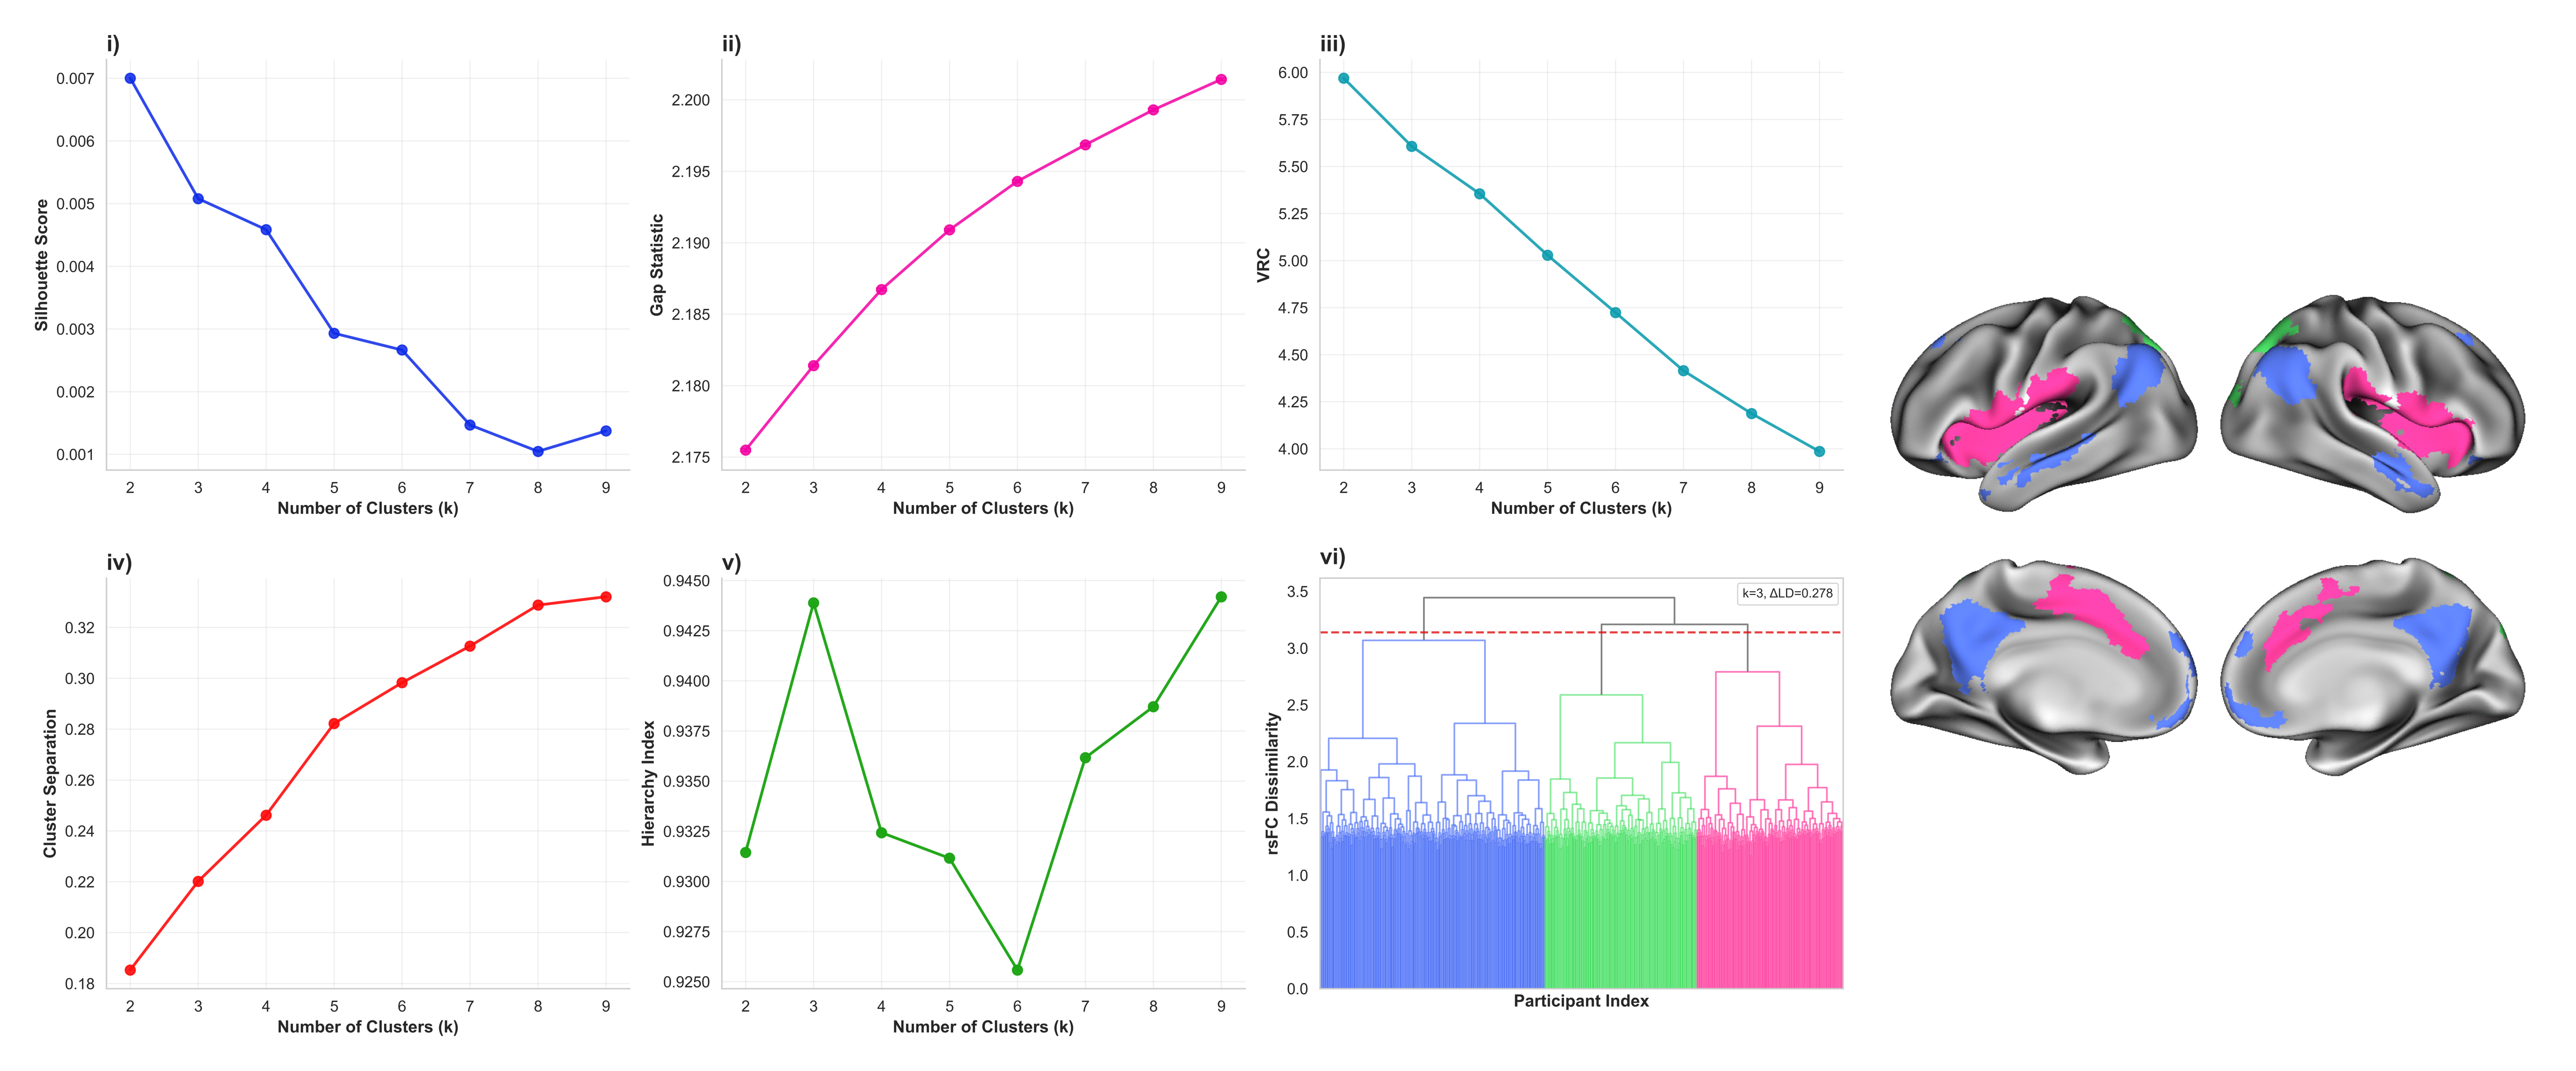

In [70]:
import matplotlib.image as mpimg
import numpy as np
from PIL import Image

metrics_path = "./figures/validation_metrics/six_plot_validation_metrics.png"
metrics = mpimg.imread(metrics_path)
surf_path = "./figures/combined_clusters/k_3_combined_surface_plot.png"
surf = mpimg.imread(surf_path)

fig = plt.figure(figsize=(13,9))
gs = fig.add_gridspec(1, 2, width_ratios=[4, 1.5], wspace=0.01)

ax_metrics = fig.add_subplot(gs[0,0])
ax_metrics.imshow(metrics)
ax_metrics.axis("off")

ax_surf = fig.add_subplot(gs[0,1])
ax_surf.imshow(np.flipud(surf), origin='lower')
ax_surf.axis("off")

complete_path = "./figures/validation_metrics/complete_validation_metrics.png"
plt.savefig(complete_path, dpi=200, bbox_inches="tight")
print(f"Saved: {complete_path}")
plt.show()

## 8. Save Figures

In [71]:
def save_metric_plot(metric_name, k_col, metric_col, color, ylabel, title):
    """Create and save a single metric plot"""
    fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.plot(df[k_col], df[metric_col], 'o-', 
            linewidth=2.5, markersize=8, color=color,
            markeredgecolor='white', markeredgewidth=1.5)
    
    ax.set_xlabel('Number of Clusters (k)', fontweight='bold')
    ax.set_ylabel(ylabel, fontweight='bold')
    ax.set_title(title, fontweight='bold', pad=15)
    ax.set_xticks(df[k_col])
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    
    for ext in ['png', 'pdf', 'svg']:
        filepath = op.join(figures_dir, f'{metric_name}_validation.{ext}')
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"Saved: {filepath}")
    plt.close()

print("Saving individual metric plots...")
save_metric_plot('silhouette', 'k', 'silhouette_score', colors['silhouette'], 
                 'Silhouette Score', 'Silhouette Analysis')

save_metric_plot('vrc', 'k', 'vrc', colors['vrc'], 
                 'Variance Ratio Criterion', 'VRC Analysis')

save_metric_plot('cluster_separation', 'k', 'cluster_separation', colors['separation'], 
                 'Average Cluster Separation', 'Cluster Separation Analysis')

save_metric_plot('hierarchy_index', 'k', 'hierarchy_index', colors['hierarchy'], 
                 'Hierarchy Index', 'Hierarchy Index Analysis')

print("\n✓ All figures saved successfully!")

Saving individual metric plots...
Saved: ./figures/validation_metrics/silhouette_validation.png
Saved: ./figures/validation_metrics/silhouette_validation.pdf
Saved: ./figures/validation_metrics/silhouette_validation.svg
Saved: ./figures/validation_metrics/vrc_validation.png
Saved: ./figures/validation_metrics/vrc_validation.pdf
Saved: ./figures/validation_metrics/vrc_validation.svg
Saved: ./figures/validation_metrics/cluster_separation_validation.png
Saved: ./figures/validation_metrics/cluster_separation_validation.pdf
Saved: ./figures/validation_metrics/cluster_separation_validation.svg
Saved: ./figures/validation_metrics/hierarchy_index_validation.png
Saved: ./figures/validation_metrics/hierarchy_index_validation.pdf
Saved: ./figures/validation_metrics/hierarchy_index_validation.svg

✓ All figures saved successfully!
